In [90]:
import matplotlib.pyplot as plt
%matplotlib widget

<figure id="figure-3">
<div style="background-color: white">

![](figures/dct.svg)</div>
    
<figcaption style="text-align: center">Figure 3: A DCT can be treated as an N channel filter bank where the coefficients of the
filters are the basis functions.</figcaption></figure>

# 7 The Discrete Cosine Transform (DCT)


The DCT is a method of performing energy compaction that is rather different
from the pyramid method.  It operates on non-overlapping blocks of pixels
(typically $8 \times 8$ pixels in size) by a reversible linear transform
process, such that each block of pixels is replaced by a block of the same
number of transform coefficients.  If all the transform coefficients for a
given block are transmitted unaltered to the decoder, then the original block
of pixels can be exactly recovered by the inverse transform process.

In practise the transform coefficients are quantised before transmission, and
if energy compaction has occurred, then fewer bits will be needed to send the
coefficients than the original pixels.  A key advantage of transform-based
methods is that there is no expansion of the number of samples (the
transformed block is the same size as the original block of pixels), whereas
the previous pyramid method expands the data by
$1 + \frac{1}{4} + \frac{1}{16} + \ldots \approx 1.33$ times, which is not very desirable for data
compression.

## 7.1 Definition of the DCT


The one-dimensional form of the DCT is closely related to the Discrete Fourier
Transform (DFT).  The 1-D $N$-point DCT is defined as follows:


$$
y(k) = \sum_{n=0}^{N-1} C_{kn}\ x(n) \quad \text{for} \quad 0 \le k \le N-1 \\
  \text{where }\quad C_{0n} = \sqrt{\frac{1}{N}}  \\
    \text{and } \quad C_{kn} = \sqrt{\frac{2}{N}}\ \cos
\frac{k(n+\frac{1}{2})\pi}{N} \quad \text{for} \quad 1 \le k \le N-1
$$

The equivalent inverse DCT is:
$$
x(n) = \sum_{k=0}^{N-1} C_{kn}\ y(k) \quad \text{for} \quad 0 \le n \le N-1 \\
 \text{where $C_{kn}$ is defined as above.}\\
$$

(This is actually the Type-II DCT, and the inverse is the Type-III DCT - other types have slightly different relative phases})

We see that the forward transform is equivalent to multiplication of the
$N$-point column vector $[x(0) \ldots x(N-1)]'$ by an $N \times N$ matrix,
containing $C_{kn}$ at each location $(k,n)$, to produce the $N$-point column
vector $[y(0) \ldots y(N-1)]'$.  Similarly the inverse transform is equivalent
to multiplication of the $y$ vector by the transpose of the $C$ matrix to give
the $x$ vector.  In python3 + numpy notation these become:

`y = C @ x` and `x = C.T @ y`

Note that C is an orthonormal matrix since its inverse is just its
transpose (its rows are othogonal to each other and have unit energy).

The two-dimensional version of the DCT (as used for image compression) is a
simple extension of the above 1-D DCT.  For an $N \times N$ block of pixels,
the $N$-point 1-D DCT is first applied to each column of the block to give $N$
columns of coefficients.  Then the same 1-D DCT is applied to the rows of
these coefficients to give the 2-D transform coefficients.

In python3 + numpy notation, if the input block of pixels is matrix X, the output
block of 2-D transformed coefficients Y is given by:

`Y = (C @ (C @ X).T).T` or more simply `Y = C @ X @ C.T`

where C is the 1-D transform matrix as above.  Note that in the 2-D
transform, it does not matter whether the rows or the columns are transformed
first (because the transform is linear and separable).


C.Ty rather than Cy because working with y(k) rather than y(n) obviously so need to make sure varying k over each product of terms rather than n!
***Doesn't immediately make sense to me why the rows are orthogonal and have unit energy - think we have seen orthogonality before though***

## 7.2 Applying the DCT to images

Conceptually the 2-D DCT is applied to all non-overlapping $N \times N$ blocks
of pixels in an image (we assume that the image dimensions are exact multiples
of $N$).  However it is simplest and most efficient to perform 1-D
$N$-point DCTs on all the columns of the image first, and then repeat the
operation on the transpose of the result to transform the rows.

**First generate an 8-point 1-D Type-II DCT matrix C8**

In [91]:
from cued_sf2_lab.dct import dct_ii

C8 = dct_ii(8)

Take a look at the function `dct_ii` and list `C8` to check
that it agrees with the definitions for $C_{kn}$ given above:

In [92]:
import inspect
import IPython.display
IPython.display.Code(inspect.getsource(dct_ii), language="python")

def dct_ii(N: int) -> np.ndarray:
    """
    Generate the 1D DCT transform matrix of size N.

    Parameters:
    N (int): Size of DCT matrix required

    Returns:
    C (2D np array): 1D DCT transform matrix

    Uses an orthogonal Type-II DCT.
    Y = C * X tranforms N-vector X into Y.
    """
    C = np.ones((N, N)) / np.sqrt(N)
    theta = (np.arange(N) + 0.5) * (np.pi/N)
    g = np.sqrt(2/N)
    for i in range(1, N):
        C[i, :] = g * np.cos(theta*i)

    return C

Note: np.arange(N) generates numpy array, (0, 1, ..., N-1) - i.e. all the possible k-values. This enables us to build each row of our C matrix in each iteration of the for loop!

**Plot the rows of `C8` using `plot(C8.T)`.**

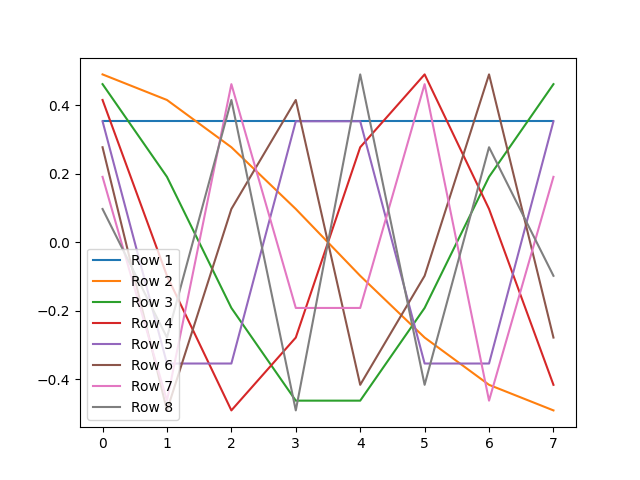

In [93]:
fig, ax = plt.subplots()

# Plot each row of C8 and add a label
for i in range(C8.shape[0]):
    ax.plot(C8[i], label=f'Row {i+1}')

# Add legend
ax.legend()

plt.show()

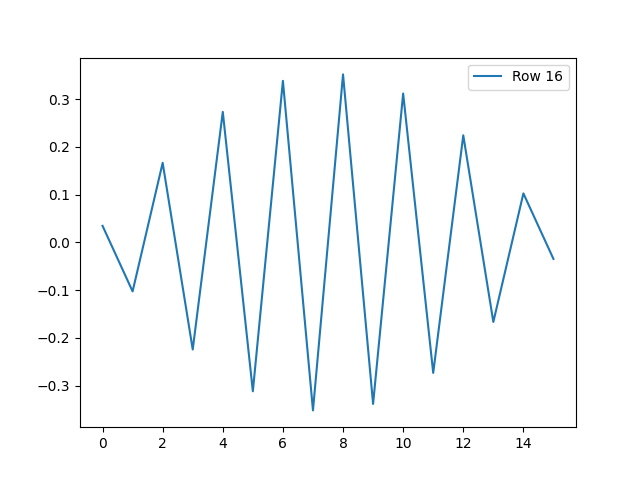

In [94]:
C16 = dct_ii(16)
fig, ax = plt.subplots()

# Plot each row of C8 and add a label
for i in range(15, C16.shape[0]):
    ax.plot(C16[i], label=f'Row {i+1}')

# Add legend
ax.legend()

plt.show()


When we calculate the 1-D transform of an 8-point block of data, each
transform coefficient represents the component of the data that is
correlated with the corresponding row of `C8`.  Hence the
first coefficient represents the dc component, the second one
represents the approximate average slope, and so on. The later
coefficients represent progressively higher frequency components
in the data.

The function `colxfm(X, C8)` will perform a 1-D transform on
the columns of image `X` using `C8`. We can
therefore perform a 2-D transform on `X` by using `colxfm` twice, once with transpose operators, as follows:

In [95]:
from cued_sf2_lab.familiarisation import load_mat_img
from cued_sf2_lab.dct import colxfm

X_pre_zero_mean, cmaps_dict = load_mat_img(img='lighthouse.mat', img_info='X', cmap_info={'map', 'map2'})
X = X_pre_zero_mean - 128.0

Y = colxfm(colxfm(X, C8).T, C8).T

In `Y`, each $8 \times 8$ block of pixels has been replaced by an
equivalent block of transform coefficients.  The coefficient in the top left
corner of each block represents the dc value of the block of pixels;
coefficients along the top row represent increasing horizontal frequency
components, and along the left column represent increasing vertical frequency
components.  Other coefficients represent various combinations of horizontal
and vertical frequencies, in proportion to their horizontal and vertical
distances from the top left corner.

If we try to display `Y` directly as an image, it is rather
confusing because the different frequency components of each block
are all present adjacent to each other.  

This idea makes intuitive sense! - dc row transformed components multiplied by column components in original image should give dc value (the average value) for that block!

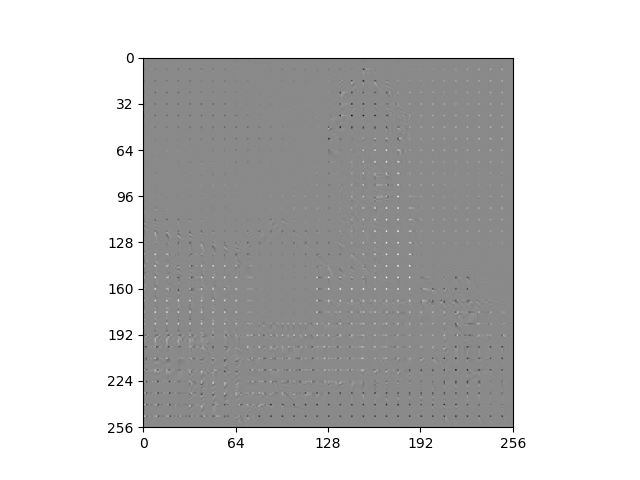

In [96]:
from cued_sf2_lab.familiarisation import plot_image

fig, ax = plt.subplots()
plot_image(Y, ax=ax);

A much more meaningful
image is created if we group all the coefficients of a given type
together into a small sub-image, and display the result as an $8
\times 8$ block of sub-images, one for each coefficient type.  The
function `regroup(Y, N)` achieves this regrouping, where $N$ is
the size of the original transform blocks. You need to ensure that X has zero mean (by subtracting 128) before you start transforming it, otherwise the dc coefficient will be purely positive, whereas the
others are symmetrically distributed about zero. Also, an $N
\times N$ 2-D DCT introduces a gain factor of $N$ in order to
preserve constant total energy between the pixel and transform
domains: we need to divide by $N$ *when displaying* to get back to the expected range.

Hence we can display `Y` meaningfully using:

***Don't understand this point - where is this gain factor in the formula and why do we need it? Also don't really understand how th e last two lines of the regroup(Y, N) function work.***

Note have already subtracted 128 above to make zero mean so fine on this.

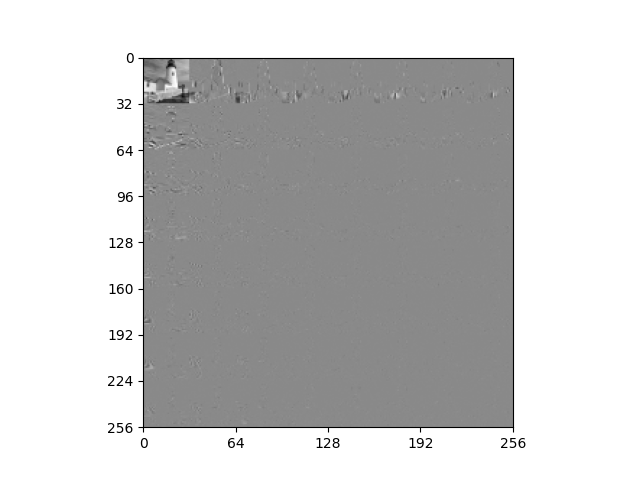

In [97]:
from cued_sf2_lab.dct import regroup

N = 8
fig, ax = plt.subplots()
plot_image(regroup(Y, N)/N, ax=ax);

In this image, you should see a small replica of the original in the top left
corner (the dc coefficients), and other sub-images showing various edges from
the original, representing progressively higher frequencies as you move
towards the lower right corner.

<div class="alert alert-block alert-danger">

What do you observe about the energies of the sub-images as frequencies
increase?</div>

***Energies become much smaller as frequencies increase (as saw in (5) and would expect for real-world images).***

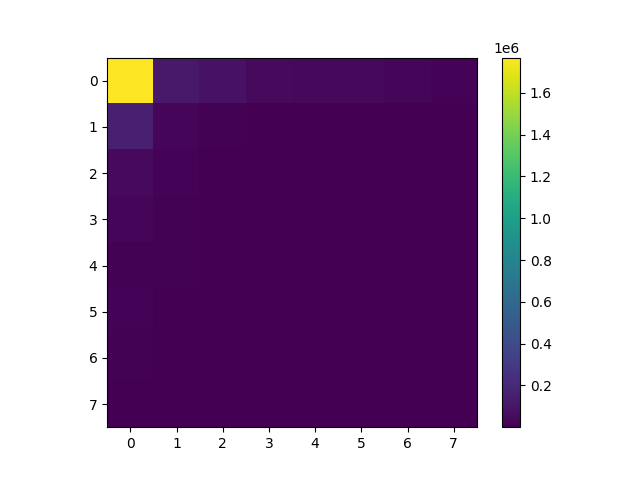

In [98]:
import numpy as np

transf_img = regroup(Y, N) / N
energy_matrix = np.zeros((N, N))
transf_block_size = 8
regroup_block_size = 256//transf_block_size

for i in range(0, transf_block_size):
    for j in range(0, transf_block_size):
        sub_img = transf_img[i*regroup_block_size:(i+1)*regroup_block_size, j*regroup_block_size:(j+1)*regroup_block_size]
        energy_sub_img = np.sum(sub_img**2.0)
        energy_matrix[i, j] = energy_sub_img

fig, ax = plt.subplots()
im_plot = ax.imshow(energy_matrix)
fig.colorbar(im_plot)

Now check that you can recover the original image from Y
by carrying out the inverse transform using:

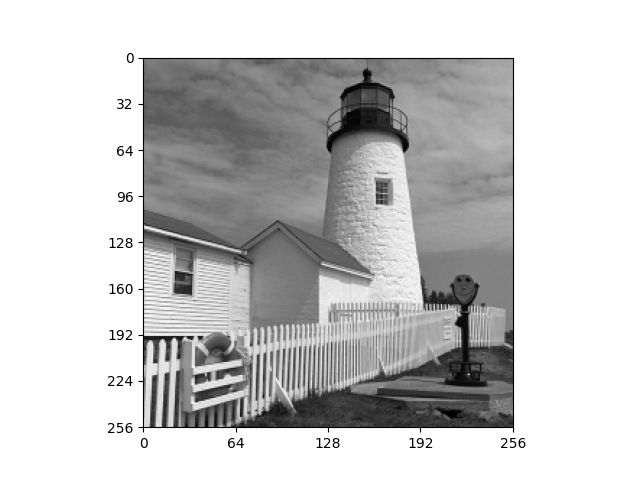

In [99]:
Z = colxfm(colxfm(Y.T, C8.T).T, C8.T)

fig, ax = plt.subplots()
plot_image(Z, ax=ax);

Easy to show X = C^T(C^TY^T)^T with some simple matrix algebra

**Measure the maximum absolute error between X and Z
to confirm this.**

In [100]:
# Your code here
err_img = X - Z
max_err = np.max(abs(X-Z))
print(f"Maximum error is: {max_err}")

Maximum error is: 6.110667527536862e-13


Maximum error negligibly small - i.e. original image can be recovered.

The DCT analyses each $8 \times 8$ block of image pixels into a linear
combination of sixty-four $8 \times 8$ basis functions.  The following will generate
an image comprising these basis functions (the `np.nan`s separate the sub-images as matplotlib draws them as transparent, and the `reshape` function converts from a matrix to a row vector):

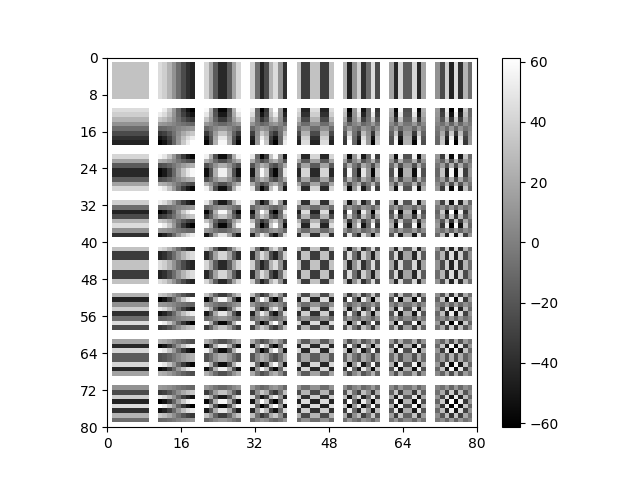

In [101]:
import numpy as np
# Stack some NaNs
bases = np.concatenate([np.full((8, 1), np.nan), C8, np.full((8, 1), np.nan)], axis=1)
# Reshape
bases_flat = np.reshape(bases, (-1, 1))

fig, ax = plt.subplots()
im = plot_image(255*bases_flat@bases_flat.T, ax=ax)
fig.colorbar(im);

If draw out matrix multiplication, will find that each element of Y is a linear combination of all 128 original components in 8x8 block of X. Coefficients in this linear combination depend on which element of Y we are looking at! Hence what we mean when talk about 64 basis functions - ***I think? This doesn't really make sense with how we have generated it though.***

The reason why it is 80x80 image and not 64x64 is because we have padded each block with NaN values to the on all sides. Hence have added an extra 16 rows and columns (2 for each block!). We pad with NaN values, then flatten the C8 matrix row-by-row (row-major) to a column vector, and then do the outer product of this column vector with itself to generated the above image matrix.

Key message behind this image matrix is above is that it shows the different frequencies of the coefficients.


<div class="alert alert-block alert-danger">

Explain how this image relates to the DCT coefficients.</div>


GPT: The image representing the 8x8 DCT basis functions visually shows each basis function as an 8x8 sub-image. Each pixel in these sub-images corresponds to an element in the 8x8 DCT basis function matrix. The intensity of each pixel represents the magnitude of that basis function's contribution to different spatial frequency components in the image.

By visualizing these basis functions:

We can observe their spatial patterns, ranging from low-frequency (smooth gradients) to high-frequency (rapid changes).
Each basis function captures different frequency components of the image.
Understanding these basis functions helps in interpreting how different frequencies contribute to the overall structure and texture of images reconstructed using the DCT coefficients.

## 7.3 Quantisation and Coding Efficiency

We are now going to look at the effects of quantising the DCT coefficients
fairly coarsely and determine the entropies of the coefficient sub-images.
At this stage we shall quantise all sub-images with the same step-size,
since they all are the same size and have unit energy gain from the
quantiser to the output image (due to the orthonormal transform matrices).

First quantise the transformed image Y using a step size
of 17 to give Yq.  Then regroup Yq to form
sub-images of each coefficient type as before, to give Yr. These sub-images have different probability distributions and we can take advantage of this later in coding them efficiently. Hence we get a better estimate of the number of bits required to code Yq by looking at the entropies of each of the re-grouped sub-images separately.

**Write a function `dctbpp(Yr, N)` to calculate the total number of bits from a re-grouped image Yr, by using `bpp(Ys)` on each sub-image Ys of Yr, then multiplying each result by the number of pixels in the sub-image, and summing to give the total number of bits.**

Can motivate the unit energy gain by thinking about the determinant of QA where Q is an orthonormal matrix. The determinant of an orthonormal matrix is always either +1 or -1 - as saw in 3M1/2P7.

In [102]:
from cued_sf2_lab.laplacian_pyramid import bpp, quantise

def dctbpp(Yr, N):
    m, n = Yr.shape
    if m % N != 0 or n % N != 0:
        raise ValueError('Height/width of Yr not multiple of N')
    
    entropy_sum = 0
    for i in range(0, m, m//N):
        for j in range(0, n, n//N):
            sub_img = Yr[i:i+m//N, j:j+n//N]
            sub_img_ent = bpp(sub_img) * sub_img.size
            entropy_sum += sub_img_ent

    return entropy_sum

<div class="alert alert-block alert-danger">

Visualise Yr and comment on the distributions in each of the sub-images. Use the function `dctbpp(Yr, N)` that you have written to calculate the total number of bits, and compare it with just using `bpp(Yr)`, explaining your results.

</div>

Entropy of Yr using dctbpp is 97467.19741586194
Entropy of Yr using bpp is 109626.49318603268


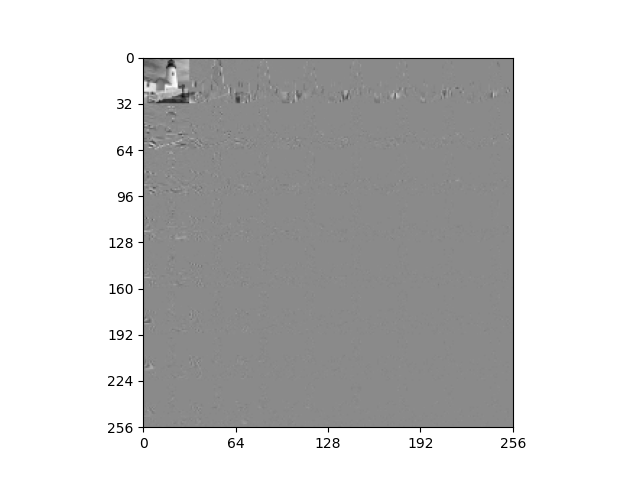

In [103]:
Yq = quantise(Y, 17)
N = 8
Yr = regroup(Yq, N)
Yr_entropy = dctbpp(Yr, N)
print(f"Entropy of Yr using dctbpp is {Yr_entropy}")

Yr_entropy_bpp = bpp(Yr)*Yr.size
print(f"Entropy of Yr using bpp is {Yr_entropy_bpp}")

# Your code here
fig, ax = plt.subplots()
plot_image(Yr, ax=ax)

bpp(Yr) produces higher entropy than dctbpp(Yr, N). This is because when we consider blocks of size NxN in dctbpp(Yr, N), the entropy of some blocks is very small and hence they contribute a negligible amount to the overall sum. However, bpp(Yr) calculates bpp for the whole image and hence doesn't neglect blocks with low entropy in the same way.

Can motivate this with the idea that if we don't know where our greatest variation occurs in our image, have to use more bits as can't simply just focus more bits where this variation occurs!

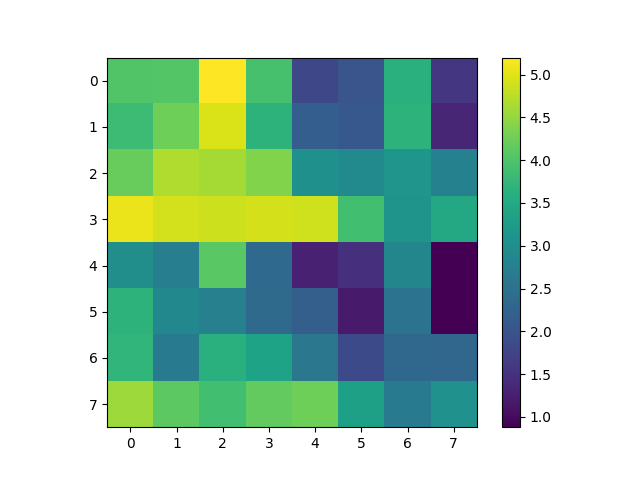

In [104]:
def dctbpp_matrix(Yr, N):
    m, n = Yr.shape
    if m % N != 0:
        raise ValueError('Height/width of Yr not multiple of N')
    
    bpp_matrix = np.zeros((N, N))

    for i in range(0, N):
        for j in range(0, N):
            sub_img = Yr[i*N:(i+1)*N, j*N:(j+1)*N]
            bpp_matrix[i, j] = bpp(sub_img)

    return bpp_matrix

bpp_matrix = dctbpp_matrix(Yr, N)

fig, ax = plt.subplots()
im_plot = ax.imshow(bpp_matrix)
fig.colorbar(im_plot)

Clear trend that as column frequency increases, the bpp decreases. Bpp also seems to decrease as row frequency increases, but not to a far less extent. This sort of makes sense - more high frequency variation in row direction in image (e.g. more in the clouds, the lighthouse and cabin). Not hugely different and may not be able to see this in original image - i.e. not a huge difference in each direction on the colour map.

<div class="alert alert-block alert-danger">

Now reconstruct the output image `Z` from `Yq` and measure the rms
error (standard deviation) between `X` and `Z`.  Compare this with the
error produced by quantising `X` with a step-size of 17 to give `Xq`.

</div>

In [105]:
# Your code here
Z = colxfm(colxfm(Yq.T, C8.T).T, C8.T)

err_img = X - Z
max_err = np.std(X-Z)
print(f"Rms error is: {max_err}")
print(f"Refernece rms error is {np.std(X-quantise(X, 17))}")

"""
fig, ax = plt.subplots()
plot_image(Z, ax=ax);
"""

Rms error is: 3.756757368843634
Refernece rms error is 4.861168497356846


'\nfig, ax = plt.subplots()\nplot_image(Z, ax=ax);\n'

***As with the Laplacian Pyramid, we really need to contrast compression ratios and visual results on compressed images with the same rms error. Re-use your step optimisation code to calculate the (non-integer) step size required in this case for the same rms error as quantising X with a step-size of 17.***

In [128]:
# Your code here
def compute_err(X, step_size, C):
    Y = colxfm(colxfm(X, C).T, C).T
    Yq = quantise(Y, step_size)
    Z = colxfm(colxfm(Yq.T, C.T).T, C.T)
    return np.std(X-Z)

def find_step_equal_rms(X, C):
    target_err = np.std(X-quantise(X, 17))

    # Binary search
    low, high = 15, 30
    while high - low > 0.1:
        print(low, high)
        mid = (low + high) / 2
        err = compute_err(X, mid, C)

        if err < target_err:
            low = mid
        else:
            high = mid

    return (low + high) / 2
        
step_size_equal_rms = find_step_equal_rms(X, C8)
print(f"Step size for same rms error as direct quantisation (step size 17) is {step_size_equal_rms}")
print(compute_err(X, 23.7, C8))
print(compute_err(X, 23.1, C8))
print(np.std(quantise(X, 17) - X))
"""
print(np.std(X-quantise(X, 17)))
Y = colxfm(colxfm(X, C8).T, C8).T
Yq = quantise(Y, 23.7)
Z = colxfm(colxfm(Yq.T, C8.T).T, C8.T)
print(np.std(X-Z))
"""

15 30
22.5 30
22.5 26.25
22.5 24.375
23.4375 24.375
23.4375 23.90625
23.671875 23.90625
23.671875 23.7890625
Step size for same rms error as direct quantisation (step size 17) is 23.701171875
4.862467878651335
4.766861220313522
4.861168497356846


'\nprint(np.std(X-quantise(X, 17)))\nY = colxfm(colxfm(X, C8).T, C8).T\nYq = quantise(Y, 23.7)\nZ = colxfm(colxfm(Yq.T, C8.T).T, C8.T)\nprint(np.std(X-Z))\n'

<div class="alert alert-block alert-danger">

Calculate the compression ratio for this scheme compared to direct quantisation. Use `dctbpp` to calculate the number of bits needed. Contrast the visual appearance of the DCT-compressed image, the directly quantised image, and the original image.

</div>

In [132]:
from useful_functions import *

# Find bits for reference scheme (direct quantisation)
X_quant = quantise(X, 17)
X_quant_ent = bpp(X_quant) * X_quant.size

# Find bits for comrpessed scheme
Y = forward_dct_lbt(X, C8)
Yq = quantise(Y, 23.7)
N=8
Yr = regroup(Yq, N)
Yr_ent = dctbpp(Yr, N)
Z = inverse_dct_lbt(Yq, C8)

comp_ratio = X_quant_ent / Yr_ent
print(Yr_ent)
print(f"Compression ratio using step size for equal rms is {comp_ratio}")
print(f"rms error between X and Z is {np.std(X-Z)}")
print(f"rms error 2 between X and Z is {compute_err_dct_lbt(X, 23.7, C8)}")
print(f"rms error 3 between X and Z is {compute_err(X, 23.7, C8)}")


77507.06634444004
Compression ratio using step size for equal rms is 2.943203081702647
rms error between X and Z is 4.862467878651335
rms error 2 between X and Z is 4.862467878651335
rms error 3 between X and Z is 4.862467878651335


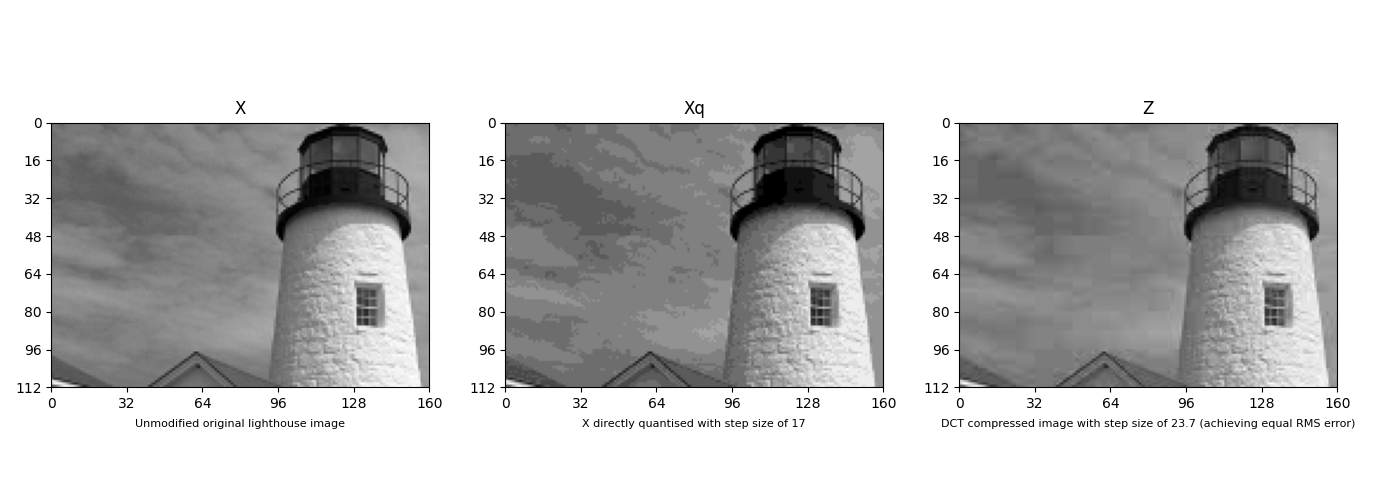

In [108]:
Z = colxfm(colxfm(Yq.T, C8.T).T, C8.T)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 5))

plot_image(X[16:128, 32:192], ax=ax1)
ax1.set_title('X')
plot_image(X_quant[16:128, 32:192], ax=ax2)
ax2.set_title('Xq')
plot_image(Z[16:128, 32:192], ax=ax3)
ax3.set_title('Z')

ax1.text(0.5, -0.15, 'Unmodified original lighthouse image', size=8, ha='center', transform=ax1.transAxes)
ax2.text(0.5, -0.15, 'X directly quantised with step size of 17', size=8, ha='center', transform=ax2.transAxes)
ax3.text(0.5, -0.15, 'DCT compressed image with step size of 23.7 (achieving equal RMS error)', size=8, ha='center', transform=ax3.transAxes)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



## 7.4 Alternative transform sizes

So far, we have concentrated on $8 \times 8$ DCTs using C8
as the 1-D transform matrix.  **Now generate 4-point and 16-point
transform matrices, C4 and C16 using `dct_ii`.**


In [109]:
# Your code here
C4 = dct_ii(4)
C16 = dct_ii(16)

<div class="alert alert-block alert-danger">

Repeat the main measurements from the previous section, so as to obtain
estimates of the number of bits and compression ratios for $4 \times 4$ and $16 \times 16$ DCTs when the
rms errors are equivalent to those in your previous tests.  Also assess the
relative subjective quality of the reconstructed images.</div>

In [110]:
Y_4 = colxfm(colxfm(X, C4).T, C4).T
step_size_4 = find_step_equal_rms(X, C4)
Yq_4 = quantise(Y_4, step_size_4)
Yr_4 = regroup(Yq_4, 4)
Yr_4_ent = dctbpp(Yr_4, 4)
comp_ratio_4 = X_quant_ent / Yr_4_ent
print(step_size_4, Yr_4_ent, comp_ratio_4)

Y_16 = colxfm(colxfm(X, C16).T, C16).T
step_size_16 = find_step_equal_rms(X, C16)
Yq_16 = quantise(Y_16, step_size_16)
Yr_16 = regroup(Yq_16, 16)
Yr_16_ent = dctbpp(Yr_16, 16)
comp_ratio_16 = X_quant_ent / Yr_16_ent
print(step_size_16, Yr_16_ent, comp_ratio_16)

15 30
22.5 30
22.5 26.25
22.5 24.375
23.4375 24.375
23.4375 23.90625
23.671875 23.90625
23.7890625 23.90625
23.876953125 86271.90902132896 2.644186724351836
15 30
15 22.5
18.75 22.5
20.625 22.5
21.5625 22.5
22.03125 22.5
22.265625 22.5
22.265625 22.3828125
22.353515625 79140.24953347181 2.8824654693842744



This analysis is in fact slightly biased because with larger transform sizes the function `dctbpp(Yr, N)` will use a greater number of smaller sub-images on which to calculate probability distributions. ***It may be better to use the same N in this function even when the actual transform changes; however whether this is more predictive of actual coding performance depends on what scanning method is used in the coding scheme.***

<div class="alert alert-block alert-danger">

What happens in the limit if you use `dctbpp(Yr, 256)` (i.e. the entropy is calculated independently for each pixel)? Why is this the case, and why isn't this a realistic result?</div>

NOTE ON THE ABOVE - i.e. the entropy and hence compression ratio for C16 may be biased to be smaller than it is in practice.

In [111]:
# Go back to C8 for this analysis
Y = colxfm(colxfm(X, C8).T, C8).T
Yq = quantise(Y, 23.7)
Yr = regroup(Yq, N)
Yr_ent = dctbpp(Yr, 256)
comp_ratio = X_quant_ent / Yr_ent
print(Yr_ent, comp_ratio)

0.0 inf


C:\Users\etown\AppData\Local\Temp\ipykernel_24572\1728958067.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  comp_ratio = X_quant_ent / Yr_ent


This is the case because when N=256, we calculate the entropy of each pixel using bpp(X). The bpp(X) function calculates the entropy by looking at the distribution of pixels in the image X - hence if there is only one pixel, the distribution contains only one value and hence the entropy is zero.

This is obviously not what we'd expect, since if the entropy is zero we should need zero bits to store Y - i.e. all the values in Y would have to be the same, which may not be the case. 

Don't worry about how we would fix this - just a limitation to be aware of and to note in your report.

<div class="alert alert-block alert-danger">

Can you draw any conclusions about the best choice of transform size for the
Lighthouse image?  Try to postulate what features in other images might make your
conclusions different, and suggest why.</div>

15 30
15 22.5
18.75 22.5
20.625 22.5
21.5625 22.5
22.03125 22.5
22.03125 22.265625
22.03125 22.1484375
15 30
22.5 30
22.5 26.25
22.5 24.375
23.4375 24.375
23.4375 23.90625
23.671875 23.90625
23.7890625 23.90625
15 30
22.5 30
22.5 26.25
22.5 24.375
23.4375 24.375
23.4375 23.90625
23.671875 23.90625
23.671875 23.7890625
15 30
15 22.5
18.75 22.5
20.625 22.5
21.5625 22.5
22.03125 22.5
22.265625 22.5
22.265625 22.3828125
15 30
15 22.5
18.75 22.5
20.625 22.5
20.625 21.5625
20.625 21.09375
20.625 20.859375
20.7421875 20.859375
15 30
15 22.5
18.75 22.5
18.75 20.625
19.6875 20.625
19.6875 20.15625
19.921875 20.15625
20.0390625 20.15625
15 30
15 22.5
15 18.75
16.875 18.75
17.8125 18.75
17.8125 18.28125
18.046875 18.28125
18.046875 18.1640625


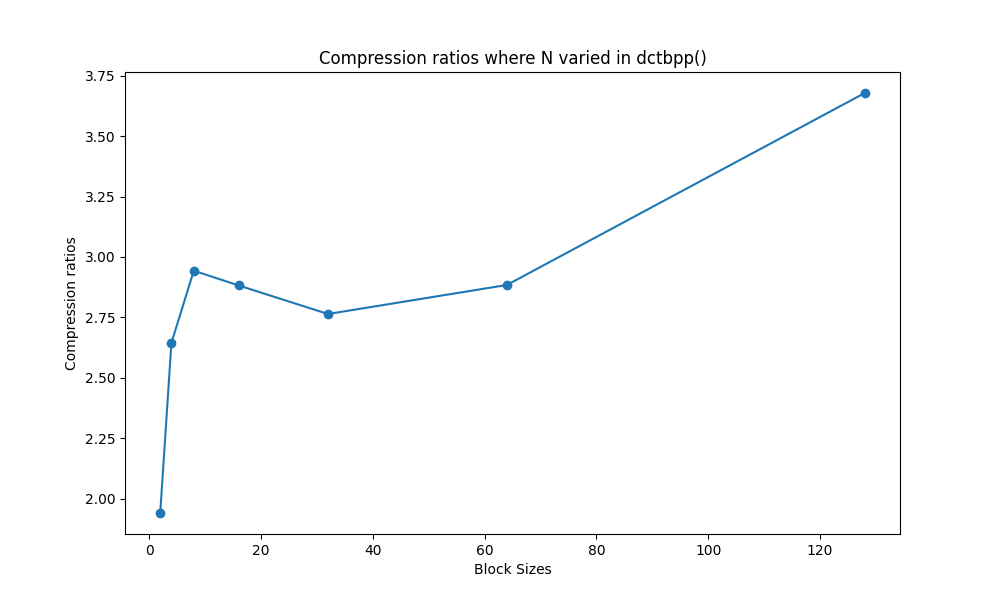

In [112]:
# Your code here
block_sizes = [2, 4, 8, 16, 32, 64, 128]

step_sizes = []
Yr_ents = []
comp_ratios = []

for i in block_sizes:
    C = dct_ii(i)
    Y = colxfm(colxfm(X, C).T, C).T
    step_size = find_step_equal_rms(X, C)
    Yq = quantise(Y, step_size)
    Yr = regroup(Yq, i)
    Yr_ent = dctbpp(Yr, i)
    comp_ratio = X_quant_ent / Yr_ent
    
    # Append values to lists
    step_sizes.append(step_size)
    Yr_ents.append(Yr_ent)
    comp_ratios.append(comp_ratio)

# Plotting with fig, ax
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(block_sizes, comp_ratios, marker='o', label='Compression Ratio')
ax.set_xlabel('Block Sizes')
ax.set_ylabel('Compression ratios')
ax.set_title('Compression ratios where N varied in dctbpp()')
plt.show()

15 30
15 22.5
18.75 22.5
20.625 22.5
21.5625 22.5
22.03125 22.5
22.03125 22.265625
22.03125 22.1484375
15 30
22.5 30
22.5 26.25
22.5 24.375
23.4375 24.375
23.4375 23.90625
23.671875 23.90625
23.7890625 23.90625
15 30
22.5 30
22.5 26.25
22.5 24.375
23.4375 24.375
23.4375 23.90625
23.671875 23.90625
23.671875 23.7890625
15 30
15 22.5
18.75 22.5
20.625 22.5
21.5625 22.5
22.03125 22.5
22.265625 22.5
22.265625 22.3828125
15 30
15 22.5
18.75 22.5
20.625 22.5
20.625 21.5625
20.625 21.09375
20.625 20.859375
20.7421875 20.859375
15 30
15 22.5
18.75 22.5
18.75 20.625
19.6875 20.625
19.6875 20.15625
19.921875 20.15625
20.0390625 20.15625
15 30
15 22.5
15 18.75
16.875 18.75
17.8125 18.75
17.8125 18.28125
18.046875 18.28125
18.046875 18.1640625


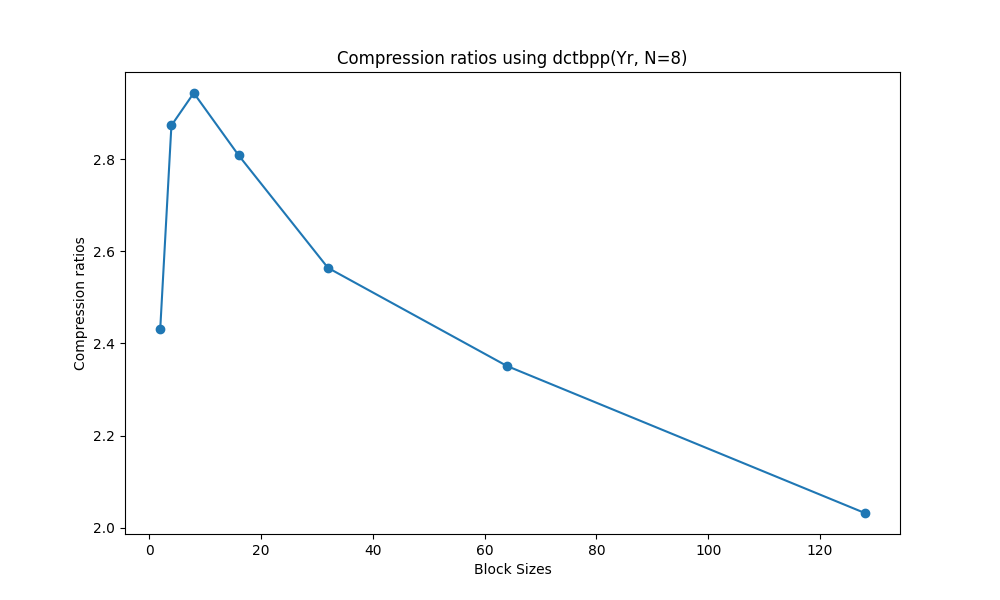

In [113]:
# Your code here
block_sizes = [2, 4, 8, 16, 32, 64, 128]

step_sizes = []
Yr_ents = []
comp_ratios = []

for i in block_sizes:
    C = dct_ii(i)
    Y = colxfm(colxfm(X, C).T, C).T
    step_size = find_step_equal_rms(X, C)
    Yq = quantise(Y, step_size)
    Yr = regroup(Yq, i)
    Yr_ent = dctbpp(Yr, 8)
    comp_ratio = X_quant_ent / Yr_ent
    
    # Append values to lists
    step_sizes.append(step_size)
    Yr_ents.append(Yr_ent)
    comp_ratios.append(comp_ratio)

# Plotting with fig, ax
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(block_sizes, comp_ratios, marker='o', label='Compression Ratio')
ax.set_xlabel('Block Sizes')
ax.set_ylabel('Compression ratios')
ax.set_title('Compression ratios using dctbpp(Yr, N=8)')
plt.show()

15 30
22.5 30
22.5 26.25
22.5 24.375
23.4375 24.375
23.4375 23.90625
23.671875 23.90625
23.7890625 23.90625
15 30
15 22.5
18.75 22.5
20.625 22.5
20.625 21.5625
20.625 21.09375
20.625 20.859375
20.7421875 20.859375


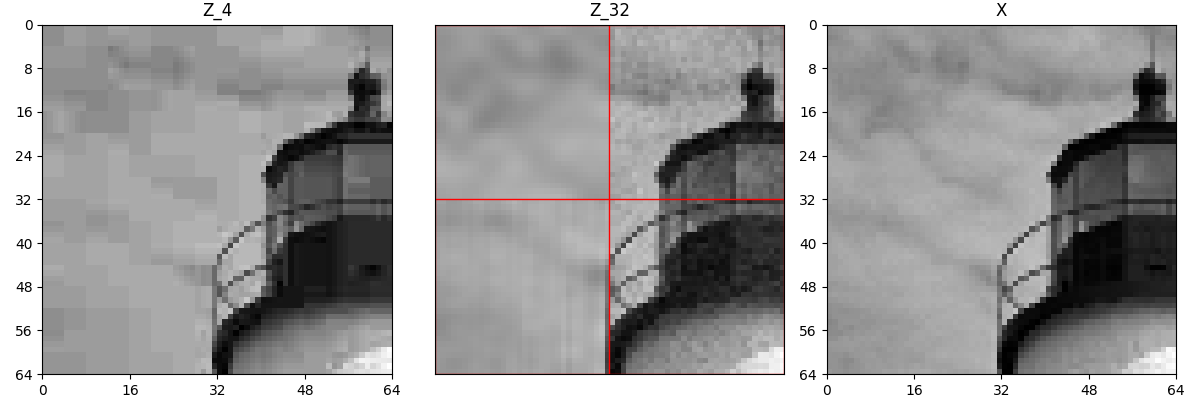

In [114]:
C32 = dct_ii(32)

Y_4 = colxfm(colxfm(X, C4).T, C4).T
step_size_4 = find_step_equal_rms(X, C4)
Yq_4 = quantise(Y_4, step_size_4)

Y_32 = colxfm(colxfm(X, C32).T, C32).T
step_size_32 = find_step_equal_rms(X, C32)
Yq_32 = quantise(Y_32, step_size_32)

Z_4 = colxfm(colxfm(Yq_4.T, C4.T).T, C4.T)
Z_32 = colxfm(colxfm(Yq_32.T, C32.T).T, C32.T)

def plot_image_with_grid(image, ax, block_size):
    ax.imshow(image, cmap='gray', aspect='equal')
    ax.set_xticks(np.arange(-0.5, image.shape[1], block_size), minor=True)
    ax.set_yticks(np.arange(-0.5, image.shape[0], block_size), minor=True)
    ax.grid(which='minor', color='r', linestyle='-', linewidth=1)
    ax.tick_params(which='minor', size=0)
    ax.set_xticks([])
    ax.set_yticks([])

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
plot_image(Z_4[0:64, 96:160], ax=axs[0])
axs[0].set(title='Z_4')

plot_image_with_grid(Z_32[0:64, 96:160], ax=axs[1], block_size=32)
axs[1].set(title='Z_32')

plot_image(X[0:64, 96:160], ax=axs[2])
axs[2].set(title='X')

plt.tight_layout()
plt.show()

Note in final competition could use block size as a parameter when trying to maximally compress an image. However, limited to powers of two obviously!

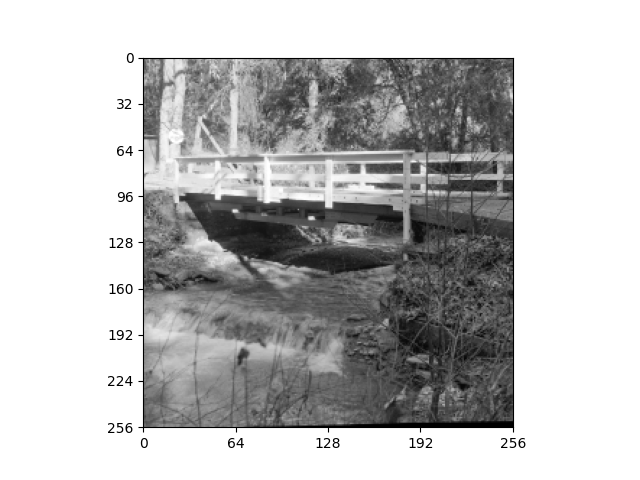

In [115]:
Xf_pre_zero_mean, cmaps_dict = load_mat_img(img='bridge.mat', img_info='X')
fig, ax = plt.subplots()
plot_image(Xf_pre_zero_mean, ax=ax)
Xf = Xf_pre_zero_mean - 128.0

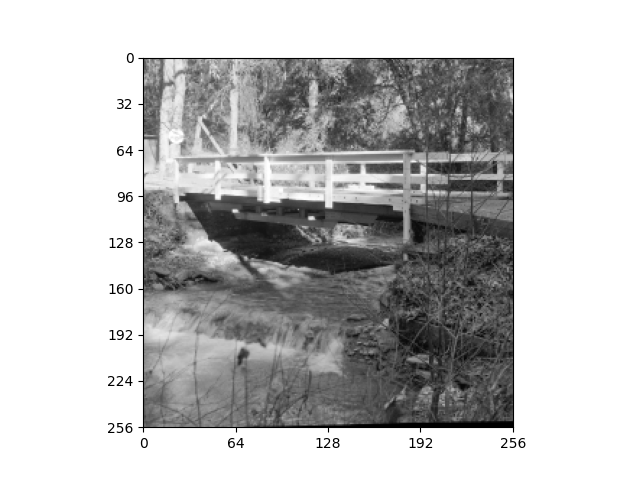

In [116]:
Xf = Xf_pre_zero_mean - 128.0
fig, ax = plt.subplots()
plot_image(Xf, ax=ax)

15 30
15 22.5
15 18.75
16.875 18.75
17.8125 18.75
17.8125 18.28125
17.8125 18.046875
17.9296875 18.046875
15 30
15 22.5
15 18.75
16.875 18.75
17.8125 18.75
17.8125 18.28125
18.046875 18.28125
18.046875 18.1640625
15 30
15 22.5
15 18.75
16.875 18.75
17.8125 18.75
17.8125 18.28125
17.8125 18.046875
17.9296875 18.046875
15 30
15 22.5
15 18.75
16.875 18.75
16.875 17.8125
17.34375 17.8125
17.578125 17.8125
17.578125 17.6953125
15 30
15 22.5
15 18.75
16.875 18.75
16.875 17.8125
17.34375 17.8125
17.578125 17.8125
17.578125 17.6953125
15 30
15 22.5
15 18.75
16.875 18.75
16.875 17.8125
17.34375 17.8125
17.34375 17.578125
17.34375 17.4609375
15 30
15 22.5
15 18.75
16.875 18.75
16.875 17.8125
16.875 17.34375
17.109375 17.34375
17.2265625 17.34375


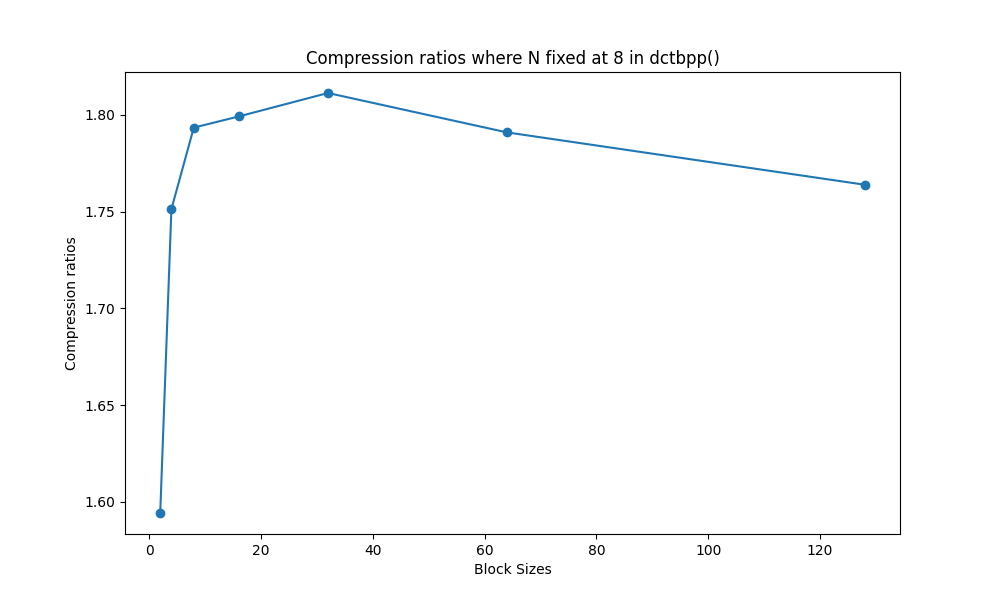

In [117]:
# Your code here
block_sizes = [2, 4, 8, 16, 32, 64, 128]

step_sizes = []
Yr_ents = []
comp_ratios = []

for i in block_sizes:
    C = dct_ii(i)
    Y = colxfm(colxfm(Xf, C).T, C).T
    step_size = find_step_equal_rms(Xf, C)
    Yq = quantise(Y, step_size)
    Yr = regroup(Yq, i)
    Yr_ent = dctbpp(Yr, 8)
    comp_ratio = X_quant_ent / Yr_ent
    
    # Append values to lists
    step_sizes.append(step_size)
    Yr_ents.append(Yr_ent)
    comp_ratios.append(comp_ratio)

# Plotting with fig, ax
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(block_sizes, comp_ratios, marker='o', label='Compression Ratio')
ax.set_xlabel('Block Sizes')
ax.set_ylabel('Compression ratios')
ax.set_title('Compression ratios where N fixed at 8 in dctbpp()')
plt.show()

15 30
15 22.5
15 18.75
16.875 18.75
17.8125 18.75
17.8125 18.28125
18.046875 18.28125
18.046875 18.1640625
15 30
15 22.5
15 18.75
16.875 18.75
16.875 17.8125
17.34375 17.8125
17.578125 17.8125
17.578125 17.6953125


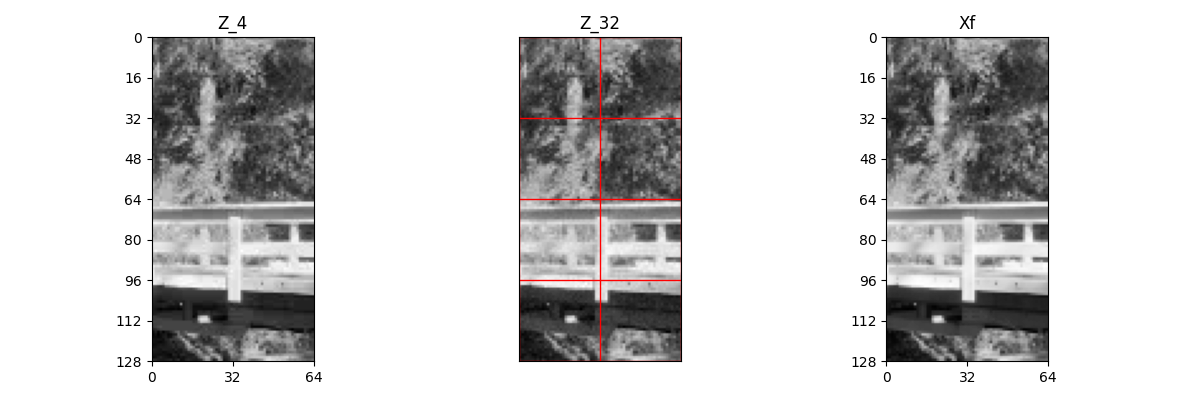

In [118]:
C32 = dct_ii(32)

Y_4 = colxfm(colxfm(Xf, C4).T, C4).T
step_size_4 = find_step_equal_rms(Xf, C4)
Yq_4 = quantise(Y_4, step_size_4)

Y_32 = colxfm(colxfm(Xf, C32).T, C32).T
step_size_32 = find_step_equal_rms(Xf, C32)
Yq_32 = quantise(Y_32, step_size_32)

Z_4 = colxfm(colxfm(Yq_4.T, C4.T).T, C4.T)
Z_32 = colxfm(colxfm(Yq_32.T, C32.T).T, C32.T)

def plot_image_with_grid(image, ax, block_size):
    ax.imshow(image, cmap='gray', aspect='equal')
    ax.set_xticks(np.arange(-0.5, image.shape[1], block_size), minor=True)
    ax.set_yticks(np.arange(-0.5, image.shape[0], block_size), minor=True)
    ax.grid(which='minor', color='r', linestyle='-', linewidth=1)
    ax.tick_params(which='minor', size=0)
    ax.set_xticks([])
    ax.set_yticks([])

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
plot_image(Z_4[0:128, 96:160], ax=axs[0])
axs[0].set(title='Z_4')

plot_image_with_grid(Z_32[0:128, 96:160], ax=axs[1], block_size=32)
axs[1].set(title='Z_32')

plot_image(Xf[0:128, 96:160], ax=axs[2])
axs[2].set(title='Xf')

plt.tight_layout()
plt.show()

In [119]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os


def process_image(input_path, output_path):
    """
    Load an image, resize it to 256x256, convert to 8-bit grayscale, and save it.
    """
    try:
        # Load the image
        img = Image.open(input_path)

        # Ensure the image is RGB (3 channels)
        img = img.convert('RGB')

        # Resize and crop to 256x256
        img = ImageOps.fit(img, (256, 256), method=Image.LANCZOS)

        # Convert to grayscale (mode 'L')
        img = img.convert('L')

        # Save the processed image
        img.save(output_path)

        print(f"Image processed and saved successfully at {output_path}")
    except Exception as e:
        print(f"An error occurred during image processing: {e}")

def load_jpg_img(img_path):
    """
    Load an image file into python as a numpy array and verify each pixel is 8-bit.
    """
    if not img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
        raise ValueError('Please provide a valid image file name with .png, .jpg, or .jpeg extension.')

    try:
        img = Image.open(img_path)
        if img.mode != 'L':
            img = img.convert('L')
        X = np.array(img)
        if np.min(X) < 0 or np.max(X) > 255:
            raise ValueError("Image does not contain 8-bit per pixel values (0-255)")

        print(f"Loaded image shape: {X.shape}") 

    except Exception as e:
        raise ValueError(f"Error loading image file '{img_path}': {e}")

    return X

# Process the image to ensure it's 256x256, 8-bit grayscale
input_image_path = 'new_images/input.jpg'
output_image_path = 'new_images/output.jpg'
process_image(input_image_path, output_image_path)

Y_pre_zero_mean = load_jpg_img(output_image_path)
Y = Y_pre_zero_mean - 128
print("Processed image shape:", Y.shape)

# Display the image using matplotlib
fig, ax = plt.subplots()
ax.set(title='Processed image')
plot_image(Y, ax=ax)
plt.show()

An error occurred during image processing: [Errno 2] No such file or directory: 'new_images/input.jpg'


ValueError: Error loading image file 'new_images/output.jpg': [Errno 2] No such file or directory: 'new_images/output.jpg'

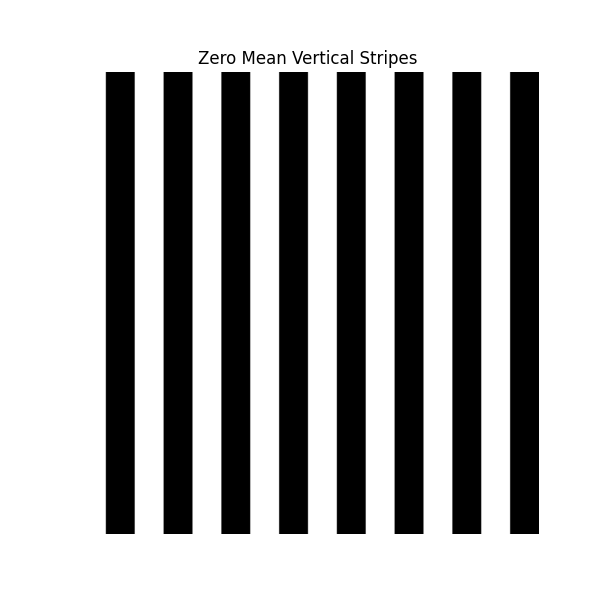

In [ ]:
stripes = np.zeros((256, 256), dtype=np.uint8)
stripe_width = 16

for col in range(256):
    if col % (2 * stripe_width) < stripe_width:
        stripes[:, col] = 255  # White stripe
    else:
        stripes[:, col] = 0    # Black stripe

# Adjust the mean to be zero
stripes = stripes.astype(np.float32) - 128.0

# Display the image using matplotlib
plt.figure(figsize=(6, 6))
plt.imshow(stripes, cmap='gray', vmin=-128, vmax=127)  # Display using grayscale colormap
plt.title('Zero Mean Vertical Stripes')
plt.axis('off')
plt.show()

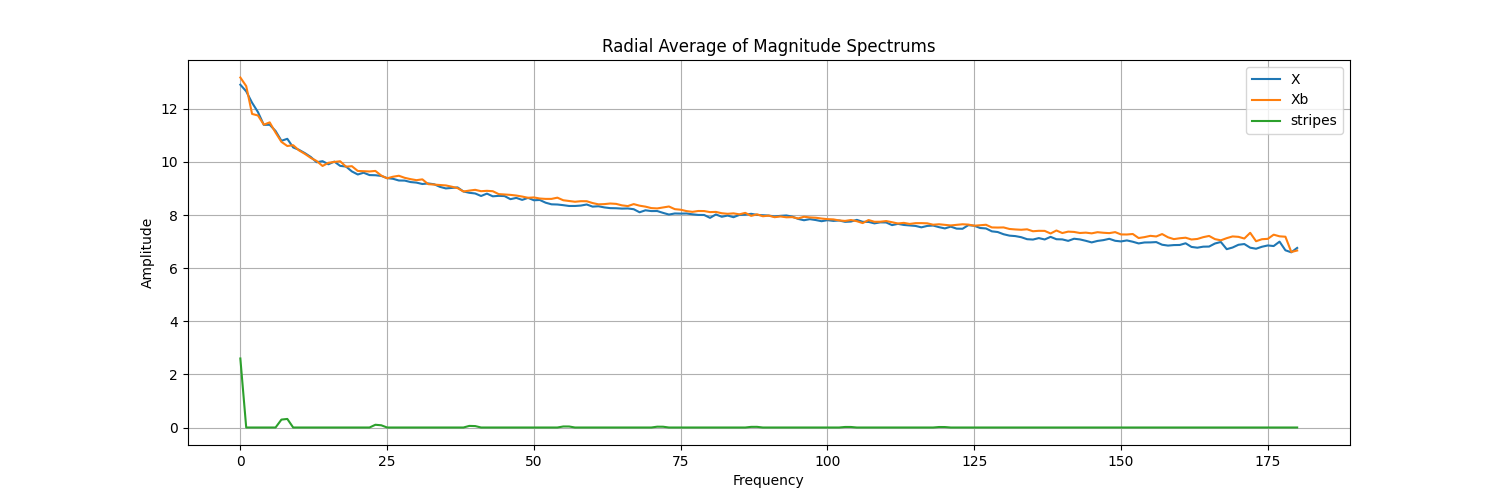

In [ ]:
from scipy.fft import fft2, fftshift

X_non_zero_mean, _ = load_mat_img(img='lighthouse.mat', img_info='X')
Xb_non_zero_mean, _ = load_mat_img(img='bridge.mat', img_info='X')
Xf_non_zero_mean, _ = load_mat_img(img='flamingo.mat', img_info='X')
X = X_non_zero_mean - 128.0
Xb = Xb_non_zero_mean - 128.0
Xf = Xf_non_zero_mean - 128.0

F_X = fft2(X)
F_shifted_X = fftshift(F_X)
magnitude_spectrum_X = np.log(np.abs(F_shifted_X) + 1)

F_Xb = fft2(Xb)
F_shifted_Xb = fftshift(F_Xb)
magnitude_spectrum_Xb = np.log(np.abs(F_shifted_Xb) + 1)

F_stripes = fft2(stripes)
F_shifted_stripes = fftshift(F_stripes)
magnitude_spectrum_stripes = np.log(np.abs(F_shifted_stripes) + 1)

def radial_profile(data):
    y, x = np.indices((data.shape))
    center = np.array([(x.max() - x.min()) / 2.0, (y.max() - y.min()) / 2.0])
    r = np.hypot(x - center[0], y - center[1])
    r = r.astype(int)  # Use 'int' instead of 'np.int'
    
    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile

radial_avg_X = radial_profile(magnitude_spectrum_X)
radial_avg_Xb = radial_profile(magnitude_spectrum_Xb)
radial_avg_Xf = radial_profile(magnitude_spectrum_stripes)

plt.figure(figsize=(15, 5))

plt.subplot(1, 1, 1)
plt.plot(radial_avg_X, label="X")
plt.plot(radial_avg_Xb, label="Xb")
plt.plot(radial_avg_Xf, label="stripes")
plt.title('Radial Average of Magnitude Spectrums')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

plt.show()

In [ ]:
plt.figure(figsize=(15, 5))

# Plot magnitude spectrum of X
plt.subplot(1, 3, 1)
plt.imshow(magnitude_spectrum_X, cmap='gray')
plt.title('Magnitude Spectrum of X')
plt.axis('off')

# Plot magnitude spectrum of Xb
plt.subplot(1, 3, 2)
plt.imshow(magnitude_spectrum_Xb, cmap='gray')
plt.title('Magnitude Spectrum of Xb')
plt.axis('off')

# Plot magnitude spectrum of Xf
plt.subplot(1, 3, 3)
plt.imshow(magnitude_spectrum_Xf, cmap='gray')
plt.title('Magnitude Spectrum of Xf')
plt.axis('off')

plt.tight_layout()
plt.show()